# Clustering of Wiggot Users

In [1]:
wiggot_colors = ((253/256,108/256,108/256), (253/256,199/256,55/256), (96/256,204/256,141/256), (0,118/256,204/256))
colors = {'red':(253/256,108/256,108/256),
          'blue':(0,118/256,204/256), 
          'yellow':(253/256,199/256,55/256), 
          'green':(96/256,204/256,141/256)}

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colormaps

import numpy as np
import pandas as pd
import os

import seaborn as sns

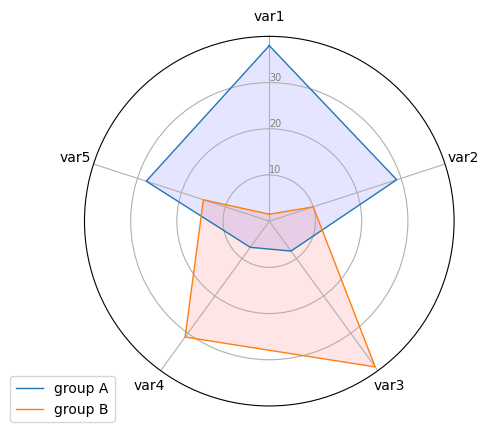

In [3]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()

## Data prep

In [4]:
def super_user_remover(X, th=4, return_filter=False):
    """
    Removes users with high utilization in one or more tools
    Asumes that everything is normalized
    """
    keep = np.logical_not(np.sum(X_ss>th, axis=1)>0)
    if return_filter:
        return keep
    return X[keep,:]

In [5]:
os.getcwd()
user_data = pd.read_excel('./data/Usuarios Wiggot.xlsx')
user_data.rename({'Tasa de accecibilidad': 'Tasa de accesibilidad', 'Portales Utiliados':'Portales Utilizados'}, axis=1, inplace=True)
user_data.drop(['fullname', '[%Key_User]'], axis=1, inplace=True)
user_data_num = user_data.drop(['State User', 'Agencia', 'Asociación', 'Antigüedad'], axis=1)
user_data_num['Paying'] = user_data_num.Plan.map({'PRIME':'Paying', 'FREE':'FREE', 'FULL':'Paying', 'PASS':'Paying', 'PRO':'Paying'})
X = user_data_num.loc[user_data['Búsquedas']>0]

In [6]:
X_strip = X.loc[:, ['Portales Utilizados', 
                    'Contactos Activos', 
                    'Requerimientos Renta', 
                    'Requerimientos Venta', 
                    'Fichas Compartidas', 
                    'Desarrollos Totales', 
                    'Propiedades Publicadas', 
                    'Búsquedas',
                    'Tasa de accesibilidad']]

ss = StandardScaler()
X_ss = ss.fit_transform(X_strip)

mm = MinMaxScaler(feature_range=(1,100))
X_mm = mm.fit_transform(X_strip)

In [8]:
from src.utils import pairwise_distances, phi_distance
X_dist = pairwise_distances(X_strip, metric=phi_distance, n_jobs=8)
X_mm_dist = pairwise_distances(X_mm, metric=phi_distance, n_jobs=8)

In [9]:
# Classes
paying = user_data_num.loc[user_data['Búsquedas']>0, 'Paying']
agency = user_data_num.loc[user_data['Búsquedas']>0, 'Usuario Agencia']
plan = user_data_num.loc[user_data['Búsquedas']>0, 'Plan']
super_user = super_user_remover(X_ss, th=3, return_filter=True)
super_user = pd.Series(super_user, name='Super user')

## Representation

### PCA

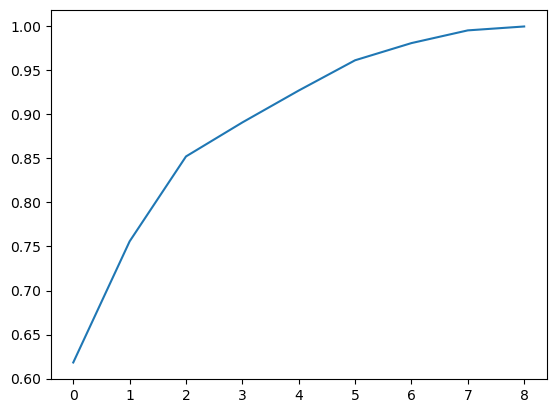

In [447]:
pca = PCA(n_components=None)
components = pca.fit_transform(X_mm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

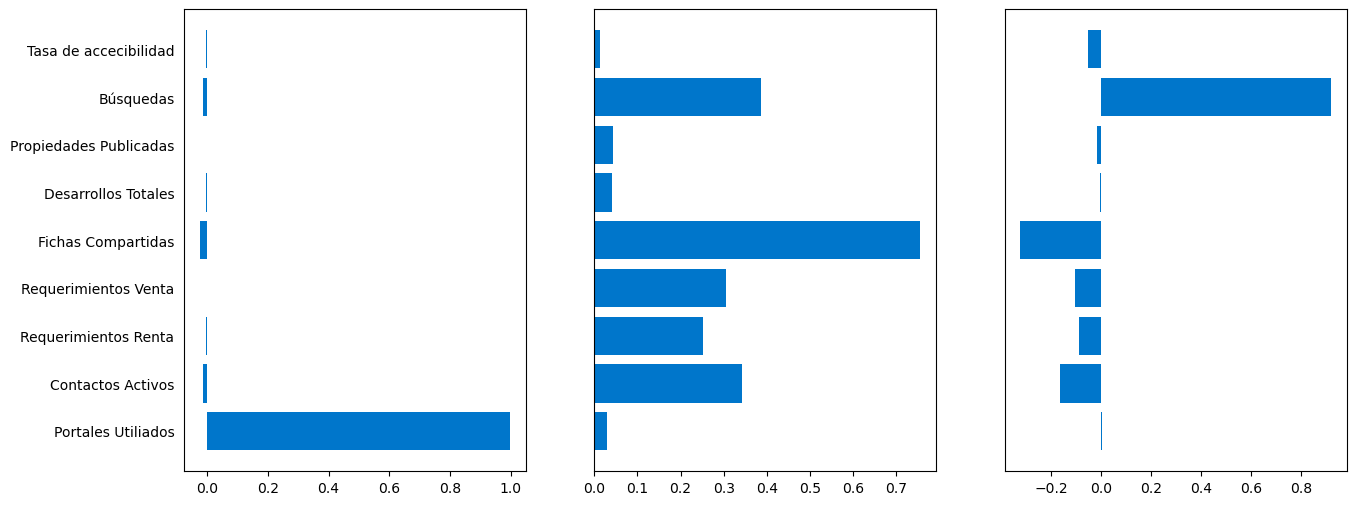

In [448]:
fig, axes = plt.subplots(1,3, figsize=(15,6))
for i, ax in enumerate(axes):
    names = X_strip.columns
    p = names.shape[0]
    ax.barh(range(p), pca.components_[i], color=colors['blue'])
    ax.tick_params(left=False)
    ax.set_yticklabels([])
    ax.

axes[0].set_yticks(range(p))
axes[0].set_yticklabels(names)
plt.show()

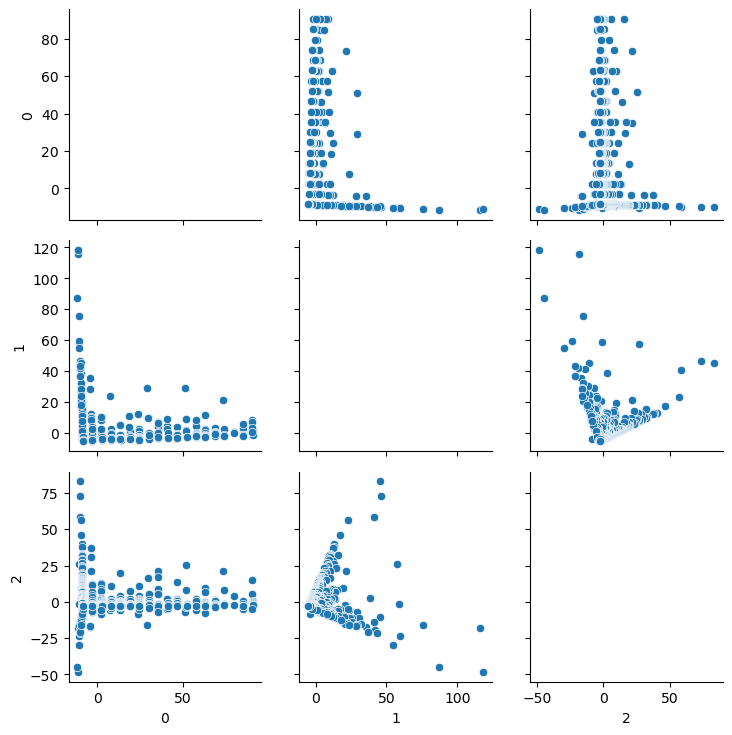

In [101]:
g = sns.PairGrid(pd.DataFrame(components[:, [0,1,2]]))
g.map_offdiag(sns.scatterplot)
plt.show()

### TSNE representation

In [10]:
X_strip_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=5000, random_state=0).fit_transform(X_strip)
X_ss_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=5000, random_state=0).fit_transform(X_ss)
X_mm_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=5000, random_state=0).fit_transform(X_mm)

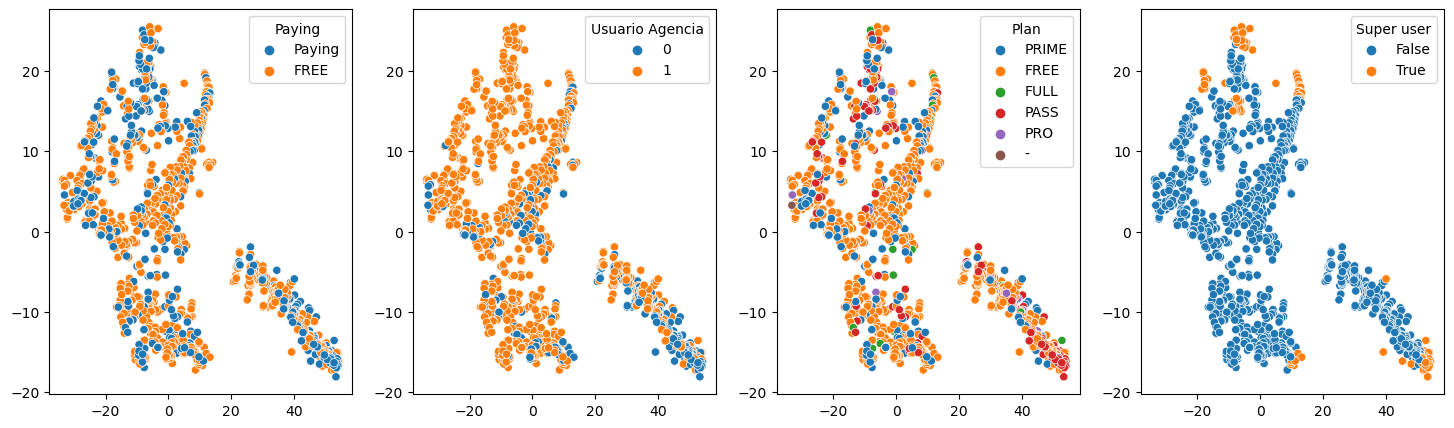

In [85]:
fig, axes = plt.subplots(1,4, figsize=(18,5))
X_to_plot = X_mm_embedded
cats = [paying, agency, plan, np.logical_not(super_user)] 
for i, category in enumerate(cats):
    sns.scatterplot(x=X_to_plot[:,0], y=X_to_plot[:,1], hue=category, ax=axes[i])

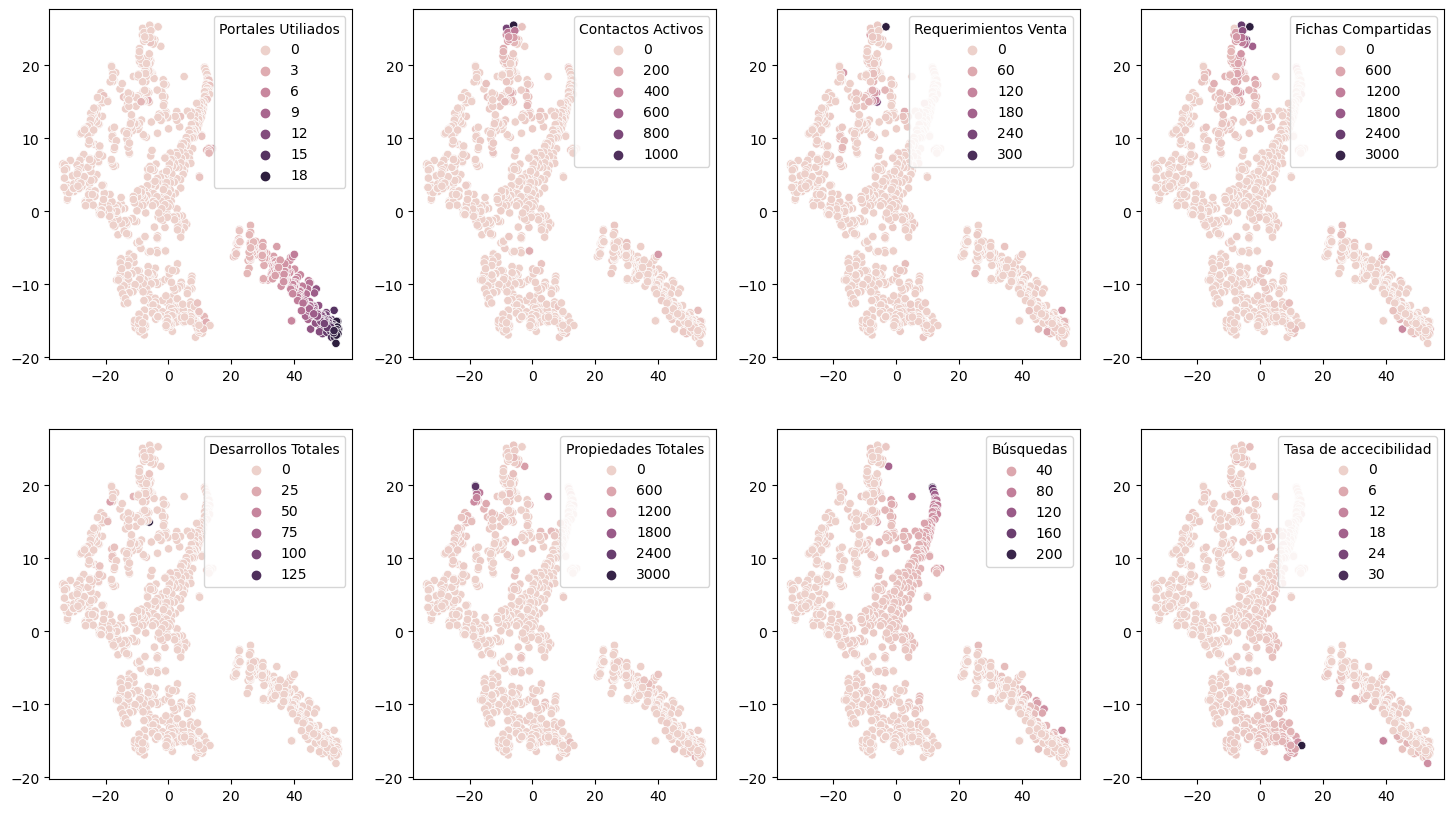

In [86]:
fig, axes = plt.subplots(2,4, figsize=(18,10))
X_to_plot = X_mm_embedded
cats = ['Portales Utiliados', 
        'Contactos Activos', 
        'Requerimientos Venta', 
        'Fichas Compartidas', 
        'Desarrollos Totales', 
        'Propiedades Totales', 
        'Búsquedas',
        'Tasa de accecibilidad']
for i, category in enumerate(cats):
    sns.scatterplot(x=X_to_plot[:,0], y=X_to_plot[:,1], hue=X_strip[category], ax=axes.flatten()[i])

## Clustering

In [17]:
from importlib import reload

In [25]:
reload(src.SilhouetteAnalysis)

<module 'src.SilhouetteAnalysis' from 'C:\\Users\\AzaelCC\\Documents\\user_clustering\\src\\SilhouetteAnalysis.py'>

In [26]:
from src.SilhouetteAnalysis import SilhouetteAnalysis

In [11]:
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering, DBSCAN, OPTICS

### Agglomerative clustering

For n_clusters = 2 The average silhouette_score is : 0.40798848741714694


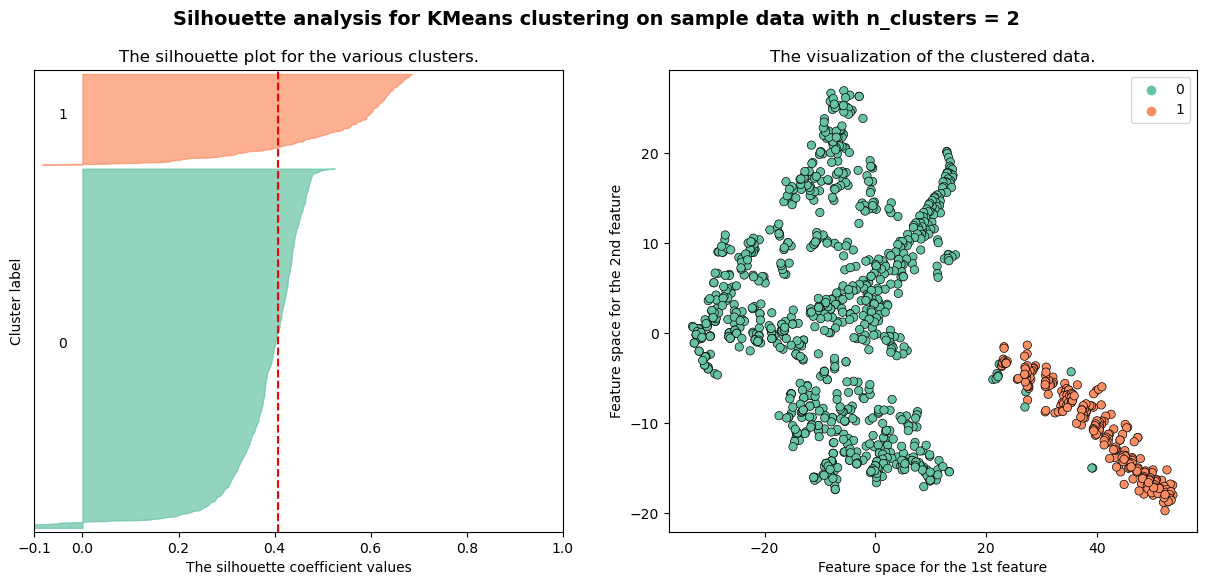

For n_clusters = 3 The average silhouette_score is : 0.24301502523895355


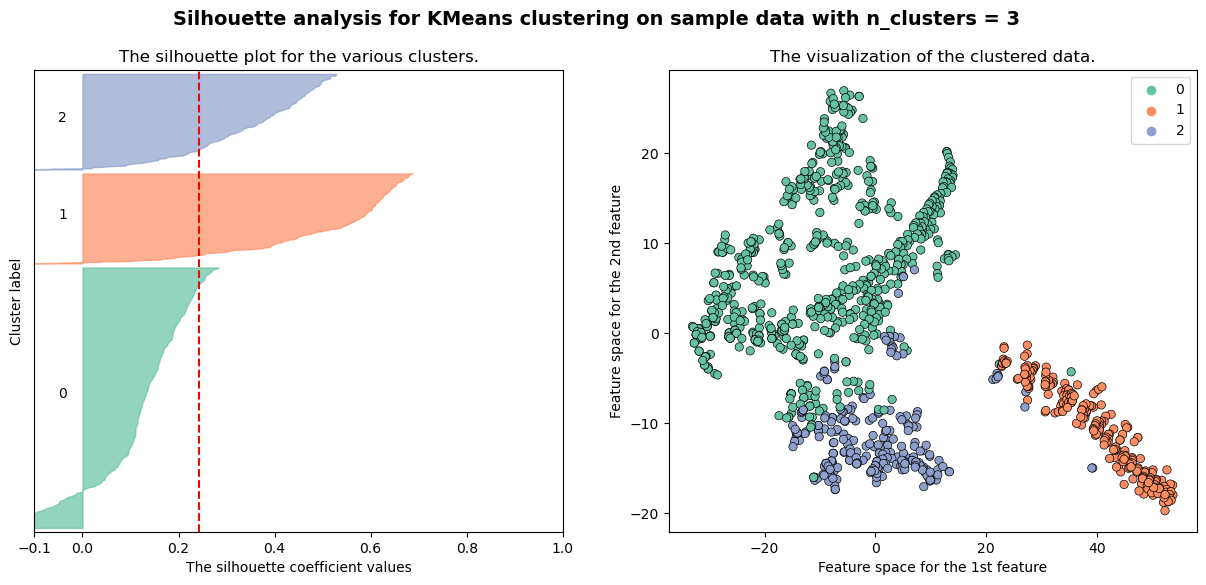

For n_clusters = 4 The average silhouette_score is : 0.248136911095799


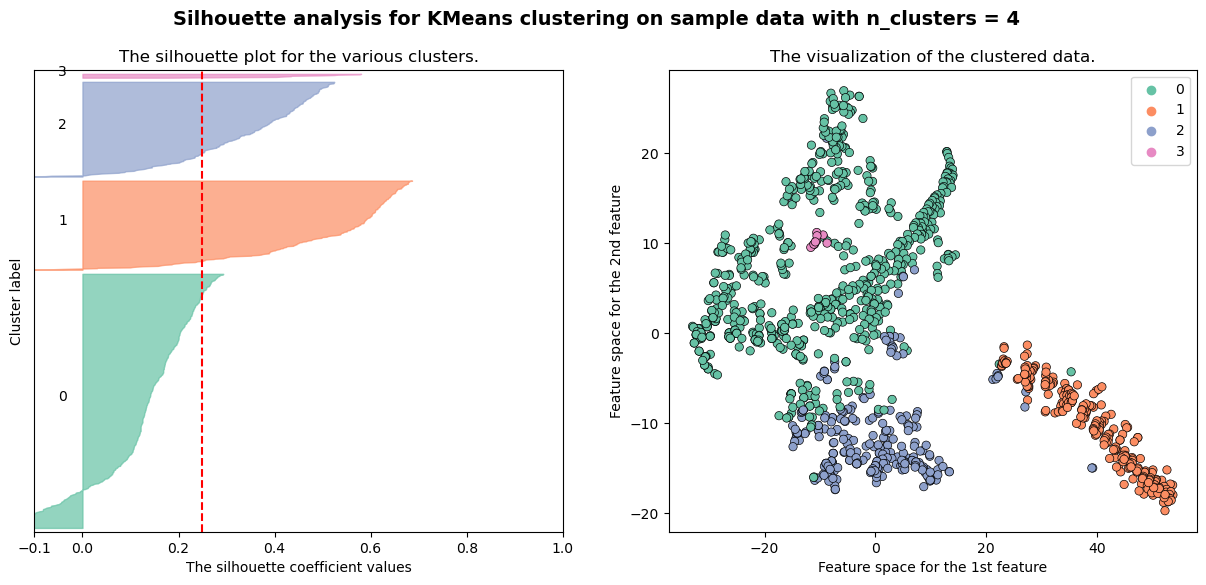

For n_clusters = 5 The average silhouette_score is : 0.25533234048468817


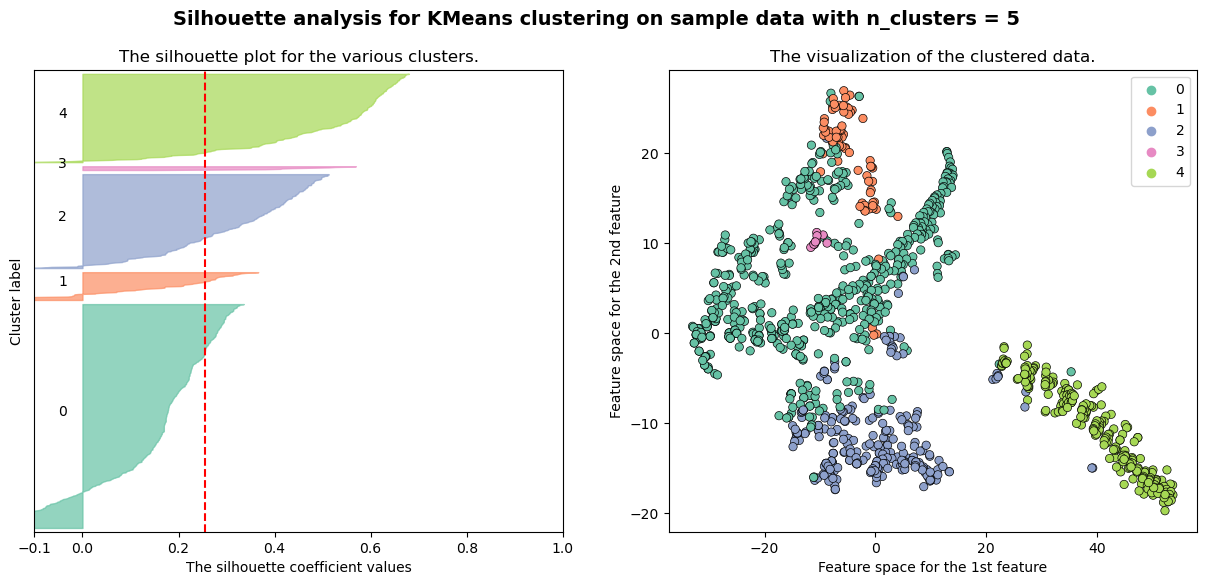

For n_clusters = 6 The average silhouette_score is : 0.2820388300880709


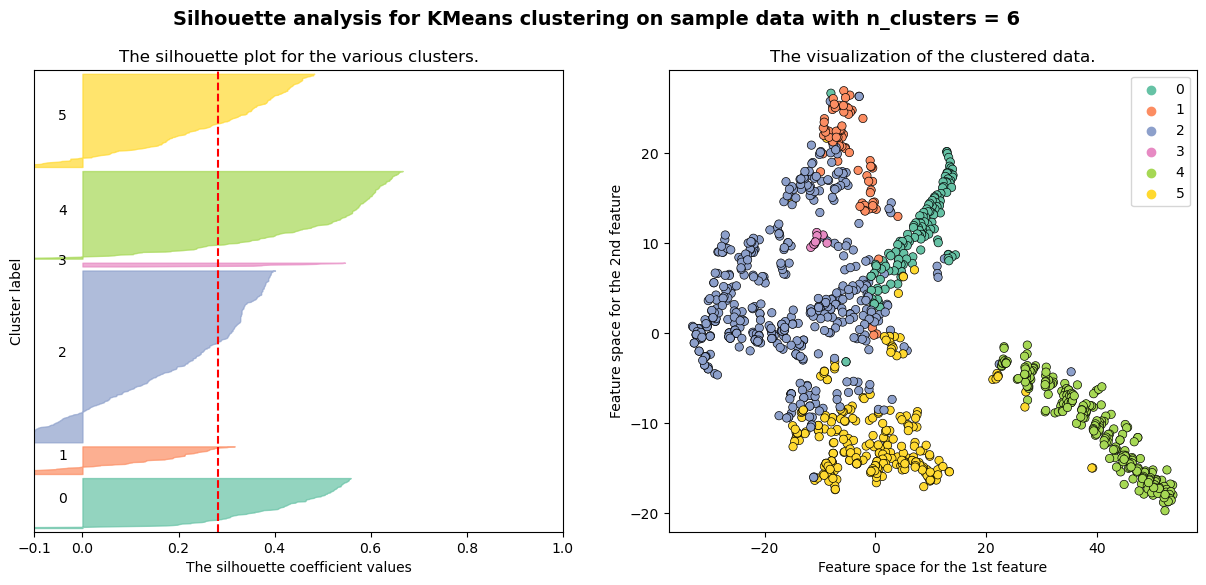

In [27]:
SA = SilhouetteAnalysis(AgglomerativeClustering, {'affinity':'precomputed', 'linkage':'complete'})
SA.analyze(X_mm_dist, x=X_mm_embedded[:,0], y=X_mm_embedded[:,1], kw_plots={'nrows':1,'ncols':2, 'figsize':(15,6)})

In [28]:
model = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='complete')
clusters = model.fit_predict(X_mm_dist)
np.unique(clusters, return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([672, 236, 251,  11], dtype=int64))

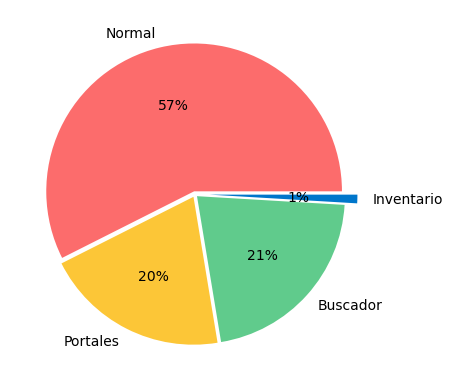

In [29]:
counts = np.unique(clusters, return_counts=True)[1]
explode = [.02, .02, .02, 0.1]
plt.pie(counts,
        explode=explode,
        colors=[colors['red'], colors['yellow'], colors['green'], colors['blue']], 
        labels=['Normal','Portales','Buscador','Inventario'], autopct='%.0f%%')

plt.savefig('figures/percent_per_cluster.png', dpi=300, transparent=True)
plt.show()

In [30]:
df = pd.DataFrame(X_ss, columns=X_strip.columns).copy()
df['cluster'] = clusters
df_mean = df.groupby('cluster').mean()

In [31]:
palette = {'Normal':colors['red'], 'Portales':colors['yellow'], 'Buscador':colors['green'], 'Inventario':colors['blue']}

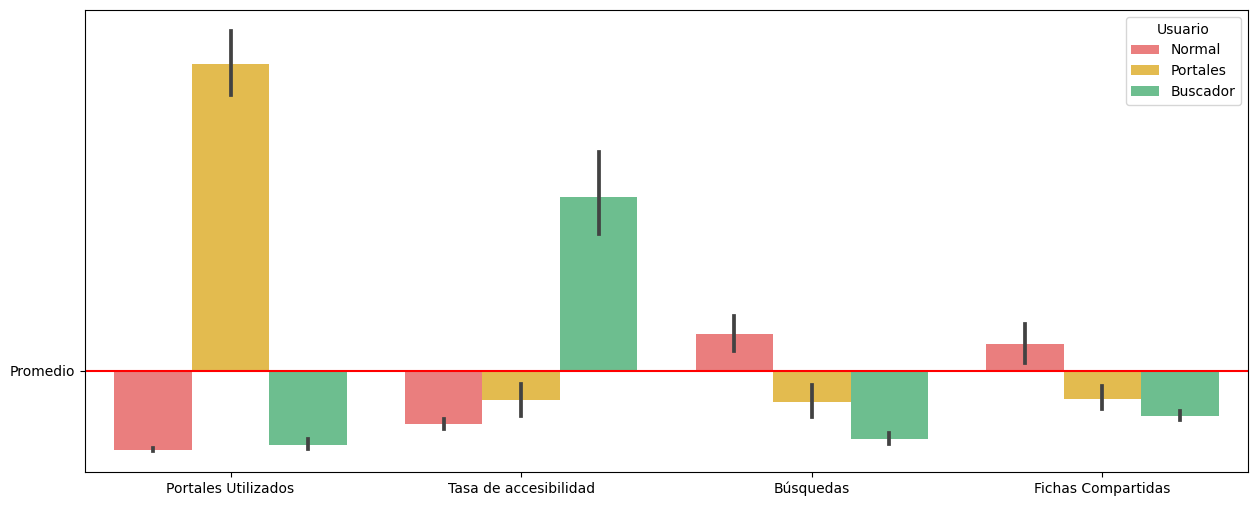

In [32]:
topvars = np.var(df_mean.loc[[0,1,2]], axis=0).sort_values(ascending=False)[0:4].index
useful_vars = np.append(topvars.values, 'cluster')
df_plot = df.loc[df.cluster !=3, useful_vars].melt(id_vars='cluster')
df_plot.cluster.replace({0:'Normal', 
                         1:'Portales' ,
                         2:'Buscador',
                         3:'Inventario'}, inplace=True)

df_plot.rename({'cluster':'Usuario'}, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df_plot, x='variable', y='value', hue='Usuario', palette=palette)
plt.xlabel('')
plt.ylabel('')
plt.yticks(ticks=[0], labels=['Promedio'])
plt.axhline(0, color='red')
plt.savefig('figures/agglomerative_topvars_noSU.png', dpi=300, transparent=True)

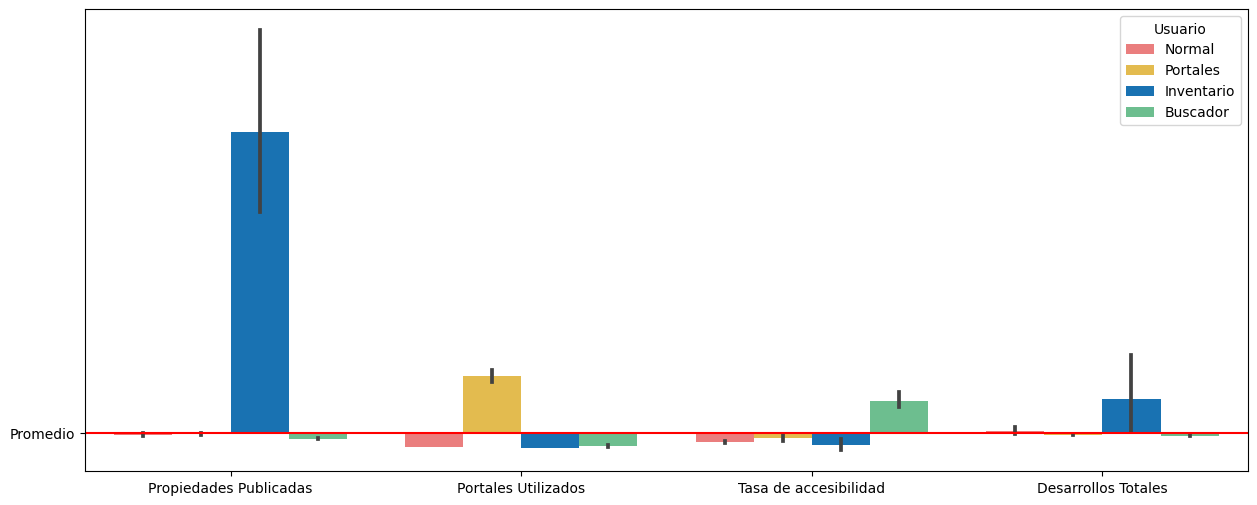

In [33]:
topvars = np.var(df_mean, axis=0).sort_values(ascending=False)[0:4].index
useful_vars = np.append(topvars.values, 'cluster')
df_plot = df.loc[:, useful_vars].melt(id_vars='cluster')

df_plot.cluster.replace({0:'Normal', 
                         1:'Portales' ,
                         2:'Buscador',
                         3:'Inventario'}, inplace=True)

df_plot.rename({'cluster':'Usuario'}, axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df_plot, x='variable', y='value', hue='Usuario', palette=palette)
plt.xlabel('')
plt.ylabel('')
plt.yticks(ticks=[0], labels=['Promedio'])
plt.axhline(0, color='red')
plt.savefig('figures/agglomerative_topvars.png', dpi=300, transparent=True)

### SpectralClustering

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.4046549465115765


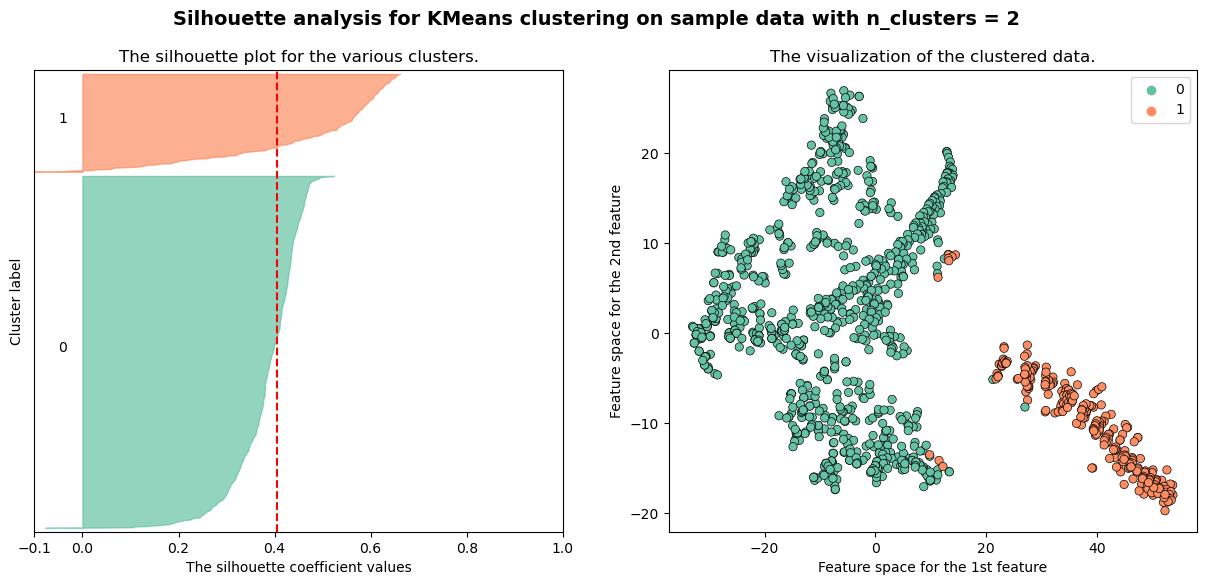

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.2950172985475017


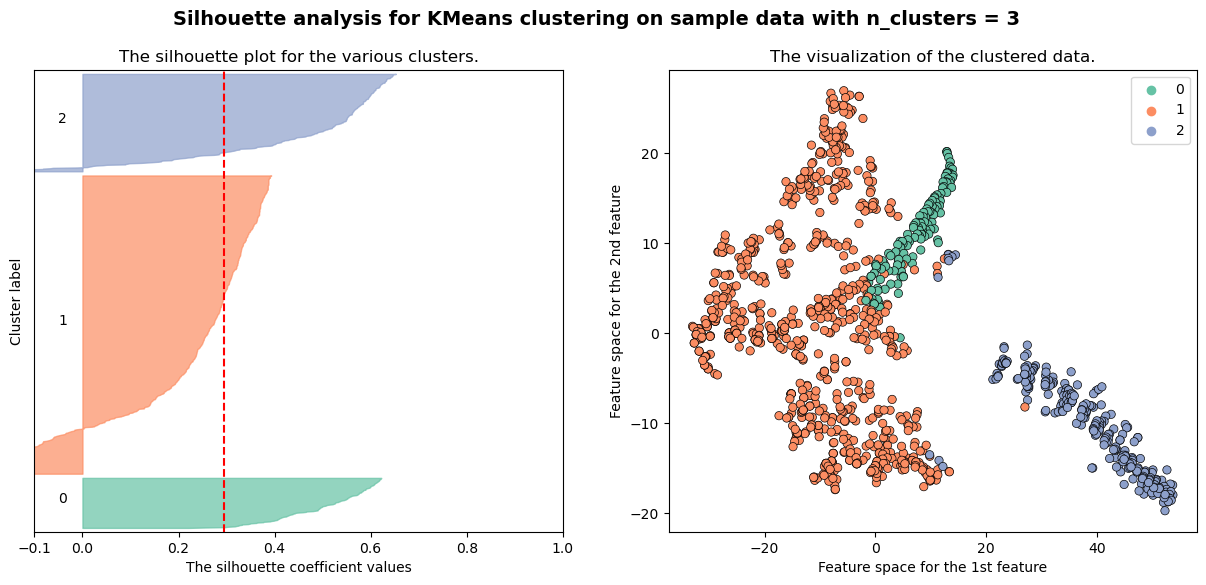

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.27469237194926555


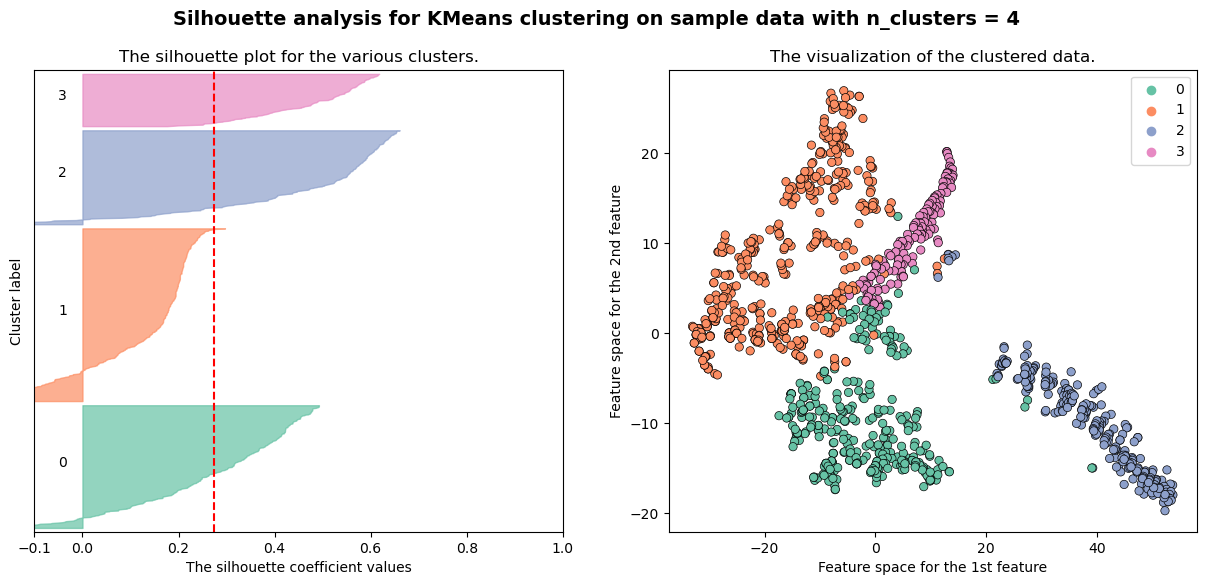

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.263245526960329


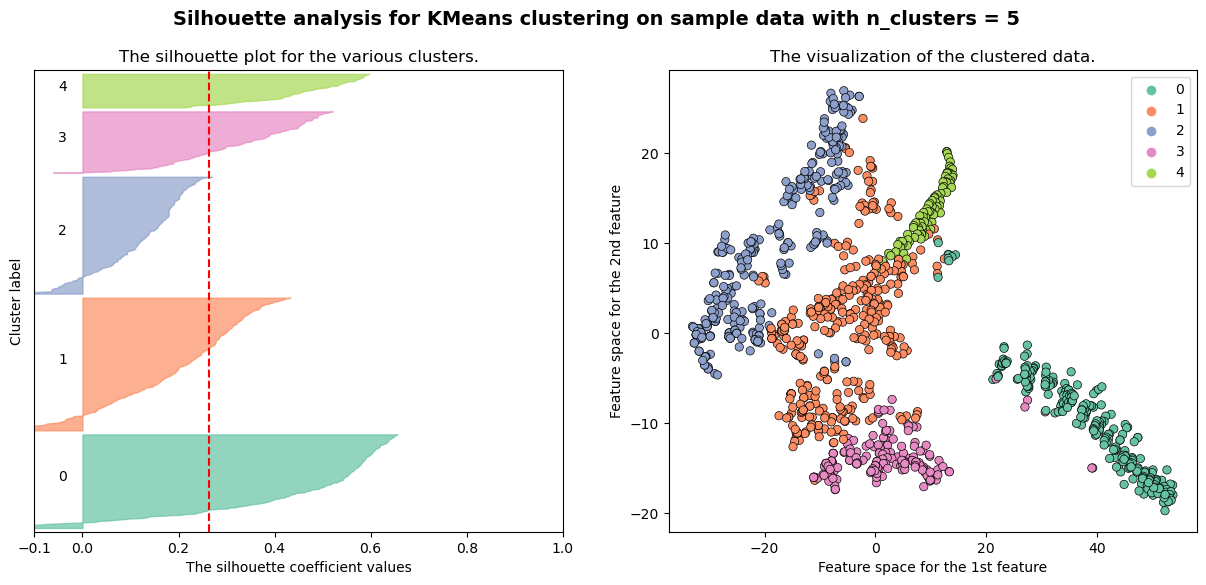

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.2712848340172764


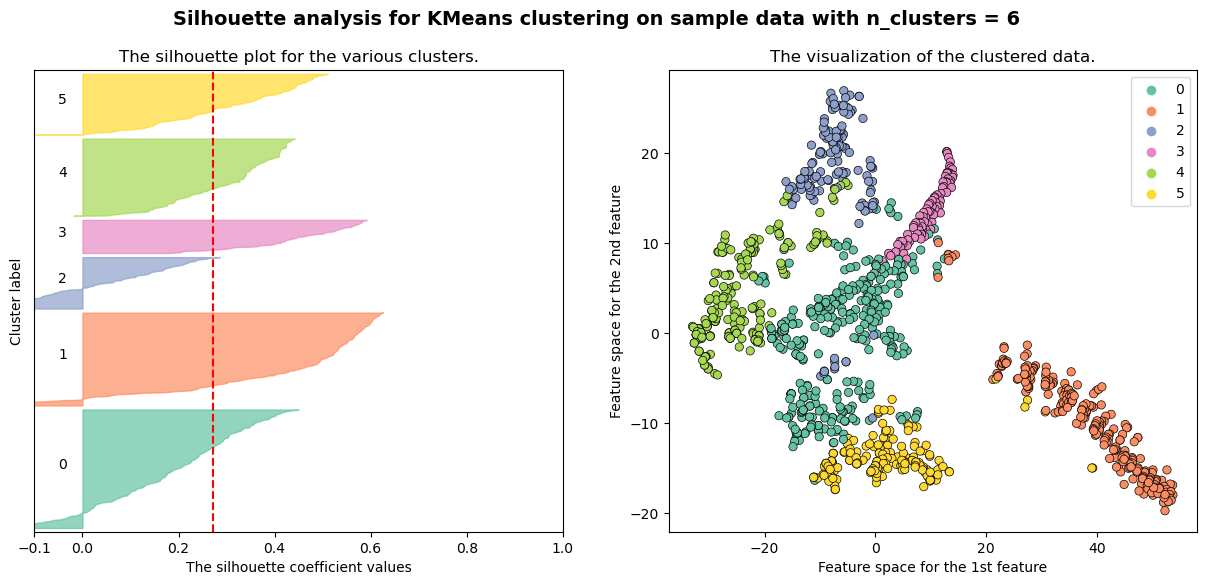

In [338]:
SA = SilhouetteAnalysis(SpectralClustering, {'affinity':'precomputed_nearest_neighbors'})
SA.analyze(X_mm_dist, x=X_mm_embedded[:,0], y=X_mm_embedded[:,1], kw_plots={'nrows':1,'ncols':2, 'figsize':(15,6)})

In [84]:
sc = SpectralClustering(n_clusters=2, affinity='precomputed_nearest_neighbors')
clusters = sc.fit_predict(X_mm_dist)
np.unique(clusters, return_counts=True)

C:\Users\AzaelCC\miniconda3\envs\EasyOCR\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


(array([0, 1]), array([915, 255], dtype=int64))